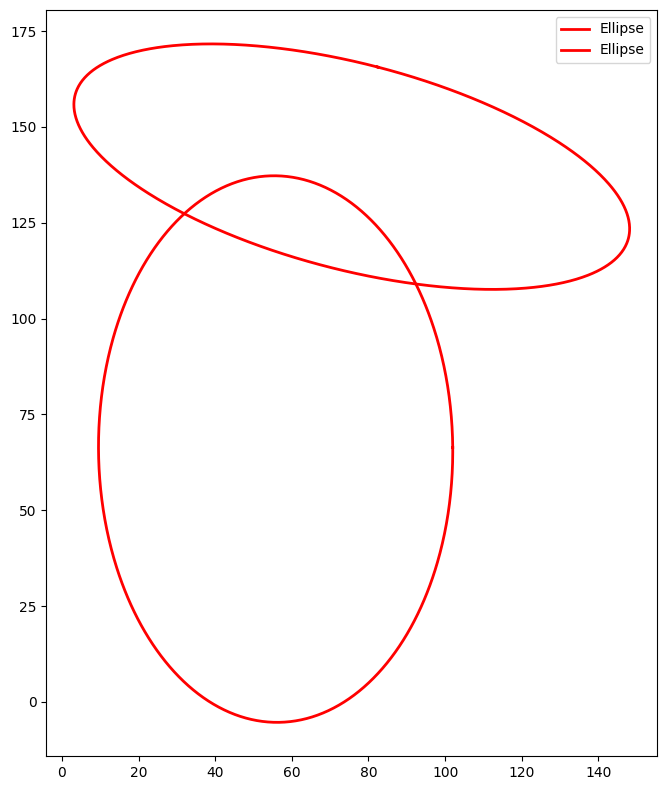

In [37]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
from scipy.interpolate import make_interp_spline, interp1d
from skimage.draw import line
import csv

# Reading the CSV file
def read_csv(csv_path):
    np_path_XYs = np.genfromtxt(csv_path, delimiter=',')
    path_XYs = []
    for i in np.unique(np_path_XYs[:, 0]):
        npXYs = np_path_XYs[np_path_XYs[:, 0] == i][:, 1:]
        XYs = []
        for j in np.unique(npXYs[:, 0]):
            XY = npXYs[npXYs[:, 0] == j][:, 1:]
            XYs.append(XY)
        path_XYs.append(XYs)
    return path_XYs

# Identify shape types
def identify_shape(contour):
    epsilon = 0.02 * cv2.arcLength(contour, True)
    approx = cv2.approxPolyDP(contour, epsilon, True)

    num_vertices = len(approx)
    area = cv2.contourArea(contour)
    perimeter = cv2.arcLength(contour, True)

    if num_vertices == 3:
        return "Triangle"
    elif num_vertices == 4:
        x, y, w, h = cv2.boundingRect(approx)
        aspect_ratio = float(w) / h
        if 0.95 <= aspect_ratio <= 1.05:
            return "Square"
        else:
            return "Rectangle"
    elif num_vertices == 5:
        return "Pentagon"
    elif num_vertices == 6:
        return "Hexagon"
    else:
        circularity = 4 * np.pi * (area / (perimeter ** 2))
        if 0.7 <= circularity <= 1.2:
            return "Circle"

        if len(contour) >= 5:
            ellipse = cv2.fitEllipse(contour)
            (center, axes, angle) = ellipse
            major_axis = max(axes)
            minor_axis = min(axes)
            if minor_axis == 0:
                return "Degenerate Ellipse"
            aspect_ratio = major_axis / minor_axis
            if aspect_ratio > 1.05:
                return "Ellipse"

        angles = []
        for i in range(num_vertices):
            p1 = approx[i][0]
            p2 = approx[(i + 1) % num_vertices][0]
            p3 = approx[(i + 2) % num_vertices][0]

            v1 = np.array([p1[0] - p2[0], p1[1] - p2[1]])
            v2 = np.array([p3[0] - p2[0], p3[1] - p2[1]])

            angle = np.arccos(np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2)))
            angles.append(np.degrees(angle))

        avg_angle = np.mean(angles)
        if num_vertices >= 10 and avg_angle < 180:
            return "Star"

        return "Polygon"

# Fit Bezier curve to points
def fit_bezier_curve(points):
    points = points[np.argsort(points[:, 0])]
    x = points[:, 0]
    y = points[:, 1]

    xnew = np.linspace(x.min(), x.max(), 300)
    spl = make_interp_spline(x, y, k=3)
    ynew = spl(xnew)

    return np.vstack([xnew, ynew]).T

# Regularize shapes
def create_precise_shape(shape_name, contour):
    if shape_name == "Circle":
        center, radius = cv2.minEnclosingCircle(contour)
        theta = np.linspace(0, 2 * np.pi, 1000)
        x = center[0] + radius * np.cos(theta)
        y = center[1] + radius * np.sin(theta)
        return np.vstack((x, y)).T
    elif shape_name == "Ellipse":
        if len(contour) < 5:
            return contour
        ellipse = cv2.fitEllipse(contour)
        center, axes, angle = ellipse
        theta = np.linspace(0, 2 * np.pi, 1000)
        x = center[0] + (axes[0] / 2) * np.cos(theta) * np.cos(np.radians(angle)) - (axes[1] / 2) * np.sin(theta) * np.sin(np.radians(angle))
        y = center[1] + (axes[0] / 2) * np.cos(theta) * np.sin(np.radians(angle)) + (axes[1] / 2) * np.sin(theta) * np.cos(np.radians(angle))
        return np.vstack((x, y)).T
    elif shape_name in ["Square", "Rectangle"]:
        x, y, w, h = cv2.boundingRect(contour)
        rect = np.array([
            [x, y],
            [x + w, y],
            [x + w, y + h],
            [x, y + h],
            [x, y]
        ])
        return rect
    elif shape_name == "Star":
        approx = cv2.approxPolyDP(contour, 0.02 * cv2.arcLength(contour, True), True)
        return approx[:, 0, :] if approx.ndim == 3 else approx
    else:
        return contour

# Refine contours with symmetry check and intersection handling
def refine_contour_with_symmetry(contour):
    epsilon = 0.005 * cv2.arcLength(contour, True)
    refined_contour = cv2.approxPolyDP(contour, epsilon, True)

    for i in range(len(refined_contour)):
        for j in range(i + 2, len(refined_contour)):
            if np.array_equal(refined_contour[i], refined_contour[j]):
                refined_contour = np.vstack((refined_contour[:i + 1], refined_contour[j:]))
                break

    return refined_contour

# Regularize shapes with symmetry
def regularize_shapes_with_symmetry(path_XYs):
    regularized_shapes = []
    for XYs in path_XYs:
        contour = np.vstack(XYs).astype(np.int32)
        shape_name = identify_shape(contour)

        refined_contour = refine_contour_with_symmetry(contour)
        precise_contour = create_precise_shape(shape_name, refined_contour)

        if shape_name in ["Circle", "Ellipse", "Star"]:
            precise_contour = np.vstack([precise_contour, precise_contour[0][np.newaxis, :]])

        regularized_shapes.append((precise_contour, shape_name))
    return regularized_shapes

# Check symmetry
def is_symmetric(contour):
    hull = ConvexHull(contour)
    simplified_contour = contour[hull.vertices]

    moments = cv2.moments(simplified_contour)
    cx = int(moments['m10'] / moments['m00'])
    cy = int(moments['m01'] / moments['m00'])

    left_part = simplified_contour[simplified_contour[:, 0] < cx]
    right_part = simplified_contour[simplified_contour[:, 0] > cx]

    if len(left_part) == 0 or len(right_part) == 0:
        return False

    left_part = np.flipud(left_part)
    right_part = np.vstack([right_part, np.array([cx, cy])])

    return np.allclose(left_part, right_part, atol=1e-2)

# Complete incomplete curves
def complete_curves(curves):
    completed_curves = []

    for curve in curves:
        if len(curve) < 2:
            continue

        for i in range(len(curve) - 1):
            pt1 = curve[i]
            pt2 = curve[i + 1]

            rr, cc = line(int(pt1[1]), int(pt1[0]), int(pt2[1]), int(pt2[0]))
            completed_curve = np.array([cc, rr]).T

            completed_curves.append(completed_curve)

    return completed_curves

# Plot shapes with error handling
def plot_shapes(regularized_shapes):
    fig, ax = plt.subplots(tight_layout=True, figsize=(8, 8))

    for contour, shape_name in regularized_shapes:
        if contour.ndim == 3 and contour.shape[1] == 1 and contour.shape[2] == 2:
            contour = contour[:, 0, :]

        if contour.ndim != 2 or contour.shape[1] != 2:
            print(f"Skipping contour with shape: {contour.shape}")
            continue

        color = 'red' if shape_name in ["Circle", "Ellipse", "Square", "Rectangle", "Star", "Polygon"] else 'blue'
        ax.plot(contour[:, 0], contour[:, 1], color=color, linewidth=2, label=shape_name)

    ax.set_aspect('equal')
    ax.legend()
    plt.show()

# Writing output to CSV
def write_csv(output_path, regularized_shapes):
    with open(output_path, mode='w', newline='') as file:
        writer = csv.writer(file)
        for i, (contour, shape_name) in enumerate(regularized_shapes):
            for j, point in enumerate(contour):
                # Ensure point is a 2D array before accessing elements
                if point.ndim == 1:
                    point = point[np.newaxis, :]
                writer.writerow([i + 1, j + 1, point[0, 0], point[0, 1]])  # Access elements correctly

# Main Execution
csv_path = '/content/occlusion1.csv'  # Update with your CSV file path
file_name, file_extension = os.path.splitext(csv_path)
output_csv_path = f"{file_name}_output{file_extension}"  # Generate output file name based on input name

path_XYs = read_csv(csv_path)
regularized_shapes = regularize_shapes_with_symmetry(path_XYs)
plot_shapes(regularized_shapes)
write_csv(output_csv_path, regularized_shapes)
